# Notebook Test File
#### Not Intended for final product

# LIBRARIES

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from statistics import mean
import IPython.display

# DATA SELCTION
Incoming data has two columns: UNIXTIME and GASDATA

In [3]:
# Set Working Directory
user      = 'adria'
subfolder = 'V 1.2.3'
file      = '2020-03-04--08EDITED.csv'
#file      = '2020-03-03--00.csv'
os.chdir('C:\\Users\\'+str(user)+'\\Desktop\\Repository\\WirelessSensorNetwork\\Data\\'
         + str(subfolder))
os.getcwd()
data = pd.read_csv(file)
data

,UNIXTIME,CO2
0,1583308801,425
1,1583308802,425
2,1583308803,425
3,1583308804,424
4,1583308805,424
...,...,...
1478,1583310279,427
1479,1583310280,428
1480,1583310281,428
1481,1583310282,428


# FUNCTIONS

## Import Data
Prime the data for filtering by turning UNIXTIME and GASDATA columns to floats and by adding DATETIME, REALDATA, and INDEX columns

In [4]:
def importData(data):
    #Create columns
    UnixTime = np.array(data['UNIXTIME'])
    GasData  = np.array(data['CO2'])
    RealData = np.ones((len(UnixTime), 1))
    Index    = np.arange(0, len(UnixTime))
    rawAllDataDF = pd.DataFrame(np.column_stack((UnixTime, GasData, RealData, Index)))
    rawAllDataDF['DateTime'] = pd.to_datetime(rawAllDataDF.iloc[:,0], unit = 's')
    rawAllDataDF.columns     = ['UnixTime', 'GasData', 'RealData', 'Index', 'DateTime']

    #Drop duplicates and change datatypes
    rawAllDataDF = rawAllDataDF.drop_duplicates(subset='UnixTime', keep='first')
    rawAllDataDF.UnixTime = rawAllDataDF.UnixTime.astype(int)
    rawAllDataDF.RealData = rawAllDataDF.RealData.astype(int)
    rawAllDataDF.Index    = rawAllDataDF.Index.astype(int)
    
    #Create dataframe
    rawAllDataNP = rawAllDataDF.to_numpy()
    return rawAllDataDF, rawAllDataNP
rawAllDataDF, rawAllDataNP = importData(data)



## Import Check
Ensure that the datatypes are correct. <br>
UNIXTIME: Int <br>
GASDATA:  Float <br>
REALDATA: Int <br>
INDEX:    Int <br>
DATETIME: Timestamp <br>
Determines extreme values within the data set <br>


In [12]:
def importCheck(rawAllDataNP, rawAllDataDF):
    #Print datatypes
    print('|----------DATA CHECKER ----------|')
    print('UNIXTIME:', rawAllDataNP[0][0], type(rawAllDataNP[0][0]))
    print('GASDATA :', rawAllDataNP[0][1], type(rawAllDataNP[0][1]))
    print('REALDATA:', rawAllDataNP[0][2], type(rawAllDataNP[0][2]))
    print('INDEX:   ', rawAllDataNP[0][3], type(rawAllDataNP[0][3]))    
    print('DATETIME:', rawAllDataNP[0][4], type(rawAllDataNP[0][4]), "\n")
    #Print extreme values
    print('Data Amt:', len(rawAllDataNP[:]))
    print('Gas  Min:', min(rawAllDataNP[:,1]))
    print('Gas  Max:', max(rawAllDataNP[:,1]))
    print('Unix Min:', min(rawAllDataNP[:,0]))
    print('Unix Min:', max(rawAllDataNP[:,0]))
       
importCheck(rawAllDataNP, rawAllDataDF)
rawAllDataDF

|----------DATA CHECKER ----------|
UNIXTIME: 1583308801 <class 'int'>
GASDATA : 425.0 <class 'float'>
REALDATA: 1 <class 'int'>
INDEX:    0 <class 'int'>
DATETIME: 2020-03-04 08:00:01 <class 'pandas._libs.tslibs.timestamps.Timestamp'> 

Data Amt: 1483
Gas  Min: 0.0
Gas  Max: 5000.0
Unix Min: 1583308801
Unix Min: 1583310283


,UnixTime,GasData,RealData,Index,DateTime
0,1583308801,425.0,1,0,2020-03-04 08:00:01
1,1583308802,425.0,1,1,2020-03-04 08:00:02
2,1583308803,425.0,1,2,2020-03-04 08:00:03
3,1583308804,424.0,1,3,2020-03-04 08:00:04
4,1583308805,424.0,1,4,2020-03-04 08:00:05
...,...,...,...,...,...
1478,1583310279,427.0,1,1478,2020-03-04 08:24:39
1479,1583310280,428.0,1,1479,2020-03-04 08:24:40
1480,1583310281,428.0,1,1480,2020-03-04 08:24:41
1481,1583310282,428.0,1,1481,2020-03-04 08:24:42


## Filter Data
Determine the indeces containing bad data. <br>
Create new PandasFrame filAllData <br>

In [6]:
def dataFilterWhere(rawAllDataNP):
    #Determine indices
    gasZerosIndices  = np.where( rawAllDataNP[:,1] == 0)
    gasLowIndices    = np.where((rawAllDataNP[:,1] <= 350) & (rawAllDataNP[:,1] > 0))
    gasHighIndices   = np.where( rawAllDataNP[:,1] >= 5000) 
    gasNegIndices    = np.where( rawAllDataNP[:,1] < 0 )
    timeZerosIndices = np.where( rawAllDataNP[:,0] == 0)
    timeLowIndices   = np.where((rawAllDataNP[:,0] <= 1576594500) & (rawAllDataNP[:,0] > 0))
    timeHighIndices  = np.where( rawAllDataNP[:,0] >= 2000000000)                            
    timeNegIndices   = np.where( rawAllDataNP[:,0] < 0)

    fullRemovalIndices = np.concatenate((
        gasZerosIndices, gasLowIndices, gasHighIndices, gasNegIndices,
        timeZerosIndices,timeLowIndices,timeHighIndices,timeNegIndices), axis = None)
    
    #Print removal info
    print('|----------DATA REMOVED----------|')
    print('Gas  Zeros: ', len(gasZerosIndices[0]))
    print('Gas   Lows: ', len(gasLowIndices[0]))
    print('Gas  Highs: ', len(gasHighIndices[0]))
    print('Gas   Negs: ', len(gasNegIndices[0]))
    print('Time Zeros: ', len(timeZerosIndices[0]))
    print('Time  Lows: ', len(timeLowIndices[0]))
    print('Time Highs: ', len(timeHighIndices[0]))
    print('Time  Negs: ', len(timeNegIndices[0]))
    print('Total Remd: ', (len(gasZerosIndices[0]) + len(gasLowIndices[0]) + 
        len(gasHighIndices [0]) + len(gasNegIndices[0]) + len(timeZerosIndices[0]) + 
        len(timeLowIndices[0]) + len(timeHighIndices[0]) + len(timeNegIndices[0])))
    print('Total Remd: ', len(fullRemovalIndices))

    #Create new dataframe
    filAllDataDF = rawAllDataDF[~rawAllDataDF.index.isin(fullRemovalIndices)]
    filAllDataNP = filAllDataDF.to_numpy()
    return filAllDataNP, filAllDataDF, fullRemovalIndices
    
filAllDataNP, filAllDataDF, fullRemovalIndices = dataFilterWhere(rawAllDataNP)

|----------DATA REMOVED----------|
Gas  Zeros:  2
Gas   Lows:  2
Gas  Highs:  2
Gas   Negs:  0
Time Zeros:  0
Time  Lows:  0
Time Highs:  0
Time  Negs:  0
Total Remd:  6
Total Remd:  6


## Frame Selection
Allows user to select viewing frame for analysis purposes. <br>
Determines theoretical length of data assuming perfect collection. <br>
Compares theoretical length to real length. <br>

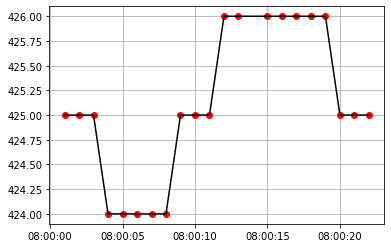

In [7]:
def windowSelect(filAllDataNP, leftFrame, rightFrame):
    #Determine validity of selected frame
    leftFrameIndex, rightFrameIndex = 0, -1
    leftSuccess,    rightSuccess    = False, False

    for i in range(0, len(filAllDataNP)):
        if (filAllDataNP[i][0] == leftFrame):
            leftFrameIndex = i
            leftSuccess = True
        if (filAllDataNP[i][0] == rightFrame):
            rightFrameIndex = i
            rightSuccess = True
            break
    
    if leftSuccess == False:
        print("Left Frame is invalid")
    if rightSuccess == False:
        print("Right Frame is invalid")

    #Create dataframe of fraAllData
    fraAllDataDF = filAllDataDF.iloc[leftFrameIndex:rightFrameIndex+1,:]
    fraAllDataNP = fraAllDataDF.to_numpy()

    #Plot selected window frame
    plt.close('all')
    x  = fraAllDataNP[leftFrameIndex:(rightFrameIndex+1),4]  
    y = fraAllDataNP[leftFrameIndex:(rightFrameIndex+1),1]
    plt.plot(x, y, "ro")
    plt.plot(x, y, "k-")
    plt.grid()

    return fraAllDataNP, fraAllDataDF

leftFrame  = filAllDataNP[0][0]
rightFrame = filAllDataNP[20][0]
fraAllDataNP, fraAllDataDF = windowSelect(filAllDataNP, leftFrame, rightFrame)

## Missing Data
Missing datapoints due to filtering of bad data, node shutdowns, module malfunctions

In [8]:
def missingDataDeterminer(data):
    leftFrameUnix  = data[0][0]
    rightFrameUnix = data[-1][0] 
    spanFrameUnix  = np.arange(leftFrameUnix, rightFrameUnix+1)
    missingData    = np.array([])

    s = set(data[:,0])
    for i in range(0, len(spanFrameUnix)):
        if spanFrameUnix[i] not in s:
            missingData = np.append(missingData, spanFrameUnix[i]) 
    print(len(missingData), "missing points from", [name for name in globals() if globals()   
        [name] is data])
    return missingData

rawMissingData = missingDataDeterminer(rawAllDataNP)
filMissingData = missingDataDeterminer(filAllDataNP)
fraMissingData = missingDataDeterminer(fraAllDataNP)

0 missing points from ['rawAllDataNP']
6 missing points from ['filAllDataNP']
1 missing points from ['fraAllDataNP']


In [9]:
%reset_selective rawAllDataDF, rawAllDataNP
#filAllDataDF = rawAllDataDF[~rawAllDataDF.index.isin(fullRemovalIndices)]

Nothing done.


## Estimate Data
If there is a missing data point in between two real data, make an estimation

In [13]:
missingFra = filAllDataNP
misDT, misGas = np.array([]), np.array([])
misReal = np.ones((len(missingFra), 1), dtype=bool)

#Perform estiamtion for every missing index
for j in missingFra:
    a = datetime.fromtimestamp(j)
    misDT = np.append(misDT, a)
    left  = j - 1
    right = j + 1
    #Check that bordering points exist
    if ((left in filAllDataNP[:,0]) & (right in filAllDataNP[:,0])) == True:
        leftIndex  = np.where(filAllDataNP[:,0] == left)
        rightIndex = np.where(filAllDataNP[:,0] == right)
        leftData   = filAllDataNP[leftIndex[0][0]][1]
        rightData  = filAllDataNP[rightIndex[0][0]][1]
        #Check that bordering points are close in value
        if (abs(leftData - rightData) <= 5.0) :
            midData = (leftData + rightData) / 2
            misGas  = np.append(misGas, midData)
        else:
            misGas  = np.append(misGas, None)
    else:
        misGas  = np.append(misGas, None)
    
unsUnix= np.concatenate((fraAllDataNP[:,0], missingFra), axis = 0)
unsGas = np.concatenate((fraAllDataNP[:,1], misGas),     axis = 0)
unsDT  = np.concatenate((fraAllDataNP[:,2], misDT),      axis = 0)
unsReal= np.concatenate((fraAllDataNP[:,3], misReal),    axis = 0)

df = pd.DataFrame(np.column_stack((unsUnix, unsGas, unsReal, DT)))
df.columns     = ['UnixTime', 'GasData', 'RealData', 'DateTime']


TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
def estimateData(missingFra):

        

    
    df  = pd.DataFrame(Datum, columns = ['UnixTime', 'GasData', 'DateTime', 'RealData'])
    dfs = df.sort_values(by = ['UnixTime'], inplace = False)
    dfs = dfs.reset_index(drop=True)
    
    dfs.UnixTime = dfs.UnixTime.astype(int)
    dfs.GasData  = dfs.GasData.astype(float)
    dfs.RealData = dfs.RealData.astype(int)
    dfs = dfs[dfs.GasData != 0.0]

    estAllDataDF = dfs.reset_index(drop=True)
    estAllDataNP = estAllDataDF.to_numpy()
    
    nanCounter   = 0
    for k in estAllDataNP[:,1]:
        if np.isnan(k) == True:
            nanCounter += 1
            
    return estAllDataNP, estAllDataDF, nanCounter
